<a href="https://colab.research.google.com/github/tokarchyn/diabetic-retinopathy-thesis/blob/master/diabetic-retinopathy-ml.ipynb" target="_parent">     
<img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [0]:
import sys
IN_COLAB = 'google.colab' in sys.modules

from matplotlib import pyplot as plt
import cv2
import numpy as np
import pandas as pd
import os
from IPython.display import display, clear_output

if IN_COLAB:
  %tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, Activation
from keras.utils.np_utils import to_categorical

from sklearn.model_selection import train_test_split
pd.options.mode.chained_assignment = None
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [0]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


##  Define constants

In [0]:
CLASS_NAMES = np.array(['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative DR'])
CLASS_INDEXES = range(0,len(CLASS_NAMES))
WIDTH = HEIGHT = 256
BATCH_SIZE = 32
BASE_IMAGE_DIR = 'drive/My Drive/Projects/diabetic-retinopathy-thesis/train_processed' if IN_COLAB else os.path.join('..', 'data', 'train')
TRAIN_LABELS_PATH = os.path.join('drive/My Drive/Colab Notebooks', 'kaggle_data', 'trainLabels.csv') if IN_COLAB else os.path.join(BASE_IMAGE_DIR, '..', 'trainLabels.csv')

## Process dataframe 

In [0]:
def load_df():
  df = pd.read_csv(TRAIN_LABELS_PATH)
  print(df.head())
  return df

def add_features(df):
  df['image_path'] = BASE_IMAGE_DIR + '/' + df['image'].astype(str) + '.jpeg'
  df['level_categorical'] = df['level'].map(lambda x: to_categorical(x, len(CLASS_NAMES)))
  return df

def remove_unexist(df):
  df['exists'] = df['image_path'].map(os.path.exists)
  df = df[df['exists']].drop(columns=['exists'])
  return df

def train_val_split(df):
  train_img, val_img = train_test_split(df['image'], 
                                        test_size = 0.20, 
                                        random_state = 2020,
                                        stratify = df['level'].to_frame())
  train_df = df[df['image'].isin(train_img)]
  val_df = df[df['image'].isin(val_img)]
  print('train', train_df.shape[0], 'val', val_df.shape[0])
  return train_df, val_df

def calc_aug_probabilities(df):
  level_counts = df['level'].value_counts().sort_index()
  aug_probs = 1 - level_counts / level_counts.max()
  print('Probabilities of augmentation for each level:\n', aug_probs)
  return aug_probs

def balancing(df):
  max_level_count = df['level'].value_counts().max()
  for level in df['level'].unique():
    if level == float('nan'):
      break
    count_of_level = df[df['level']==level].count()[0]
    if count_of_level == max_level_count:
      continue
    to_add = []
    to_add_count = max_level_count - count_of_level
    print('Need to add',to_add_count, 'copies of level', level, 'where count of level is', count_of_level)
    it = iter(df[df['level']==level].iterrows())
    while to_add_count > len(to_add):
      _, row = None, None
      try:
        _, row = next(it)
      except StopIteration:
        it = iter(df[df['level']==level].iterrows())
        _, row = next(it)
      to_add.append(row)
    df = df.append(to_add)
  return df

def shrink_dataset(df, number_of_each_level):
    levels = df['level'].unique()

    def get_rows(df_tmp):
      size = len(df_tmp)
      return df_tmp.sample(number_of_each_level) if size >= number_of_each_level else df_tmp

    df_tmp = get_rows(df[df['level'] == levels[0]])
    for l in levels[1:]:
        df_tmp = df_tmp.append(get_rows(df[df['level'] == l]))
    return df_tmp

def shuffle(df):
  df = df.sample(frac=1).reset_index(drop=True)
  return df

def prepare_data():
  df = load_df()
  df = add_features(df)
  df = remove_unexist(df)
  df = shrink_dataset(df, 700)
  df = shuffle(df)
  aug_probs = calc_aug_probabilities(df)
  train_df, val_df = train_val_split(df)
  # train_df = balancing(train_df)
  return train_df, val_df, aug_probs

In [50]:
train_df, val_df, aug_probs = prepare_data()

      image  level
0   10_left      0
1  10_right      0
2   13_left      0
3  13_right      0
4   15_left      1
Probabilities of augmentation for each level:
 0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: level, dtype: float64
train 2800 val 700


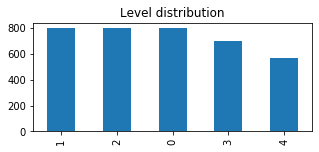

In [16]:
train_df['level'].value_counts().plot(kind='bar', figsize=(5,2), title='Level distribution')
# val_df['level'].value_counts().plot(kind='bar', figsize=(5,2), title='Level distribution')

## Build input pipeline

#### Augmentation functions

In [0]:
def rotate(x):
    # Rotate 0, 90, 180, 270 degrees
    return tf.image.rot90(x, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))

def flip(x):
    x = tf.image.random_flip_left_right(x)
    x = tf.image.random_flip_up_down(x)
    return x

def color(x):
    x = tf.image.random_hue(x, 0.04)
    x = tf.image.random_saturation(x, 0.85, 1.15)
    x = tf.image.random_brightness(x, 0.02)
    x = tf.image.random_contrast(x, 0.85, 1.15)
    return x

def zoom(x):
    # Generate 20 crop settings, ranging from a 1% to 10% crop.
    scales = list(np.arange(0.9, 1.0, 0.01))
    boxes = np.zeros((len(scales), 4))

    for i, scale in enumerate(scales):
        x1 = y1 = 0.5 - (0.5 * scale)
        x2 = y2 = 0.5 + (0.5 * scale)
        boxes[i] = [x1, y1, x2, y2]

    def random_crop(img):
        # Create different crops for an image
        crops = tf.image.crop_and_resize([img], boxes=boxes, box_indices=np.zeros(len(scales)), crop_size=(HEIGHT, WIDTH))
        # Return a random crop
        return crops[tf.random.uniform(shape=[], minval=0, maxval=len(scales), dtype=tf.int32)]

    choice = tf.random.uniform(shape=[], minval=0., maxval=1., dtype=tf.float32)

    # Only apply cropping 50% of the time
    return tf.cond(choice < 0.5, lambda: x, lambda: random_crop(x))

def augment(dataset):
  # Add augmentations
  # augmentations = [flip, color, zoom, rotate]
  augmentations = [zoom, flip, rotate]

  def augment_map(img, level, aug_fun):
    choice = tf.random.uniform(shape=[], minval=0., maxval=1., dtype=tf.float32)
    level_aug_prob = tf.math.reduce_max(tf.dtypes.cast(level, tf.float32) * aug_probs)
    return (tf.cond(choice < level_aug_prob, lambda: img, lambda: aug_fun(img)),
            level)
    
  # Add the augmentations to the dataset
  for f in augmentations:
    # Apply the augmentation, run 4 jobs in parallel.
    dataset = dataset.map(lambda img, level: augment_map(img,level,f), num_parallel_calls=4)

  # Make sure that the values are still in [0, 1]
  dataset = dataset.map(lambda img, level: (tf.clip_by_value(img, 0, 1),level), num_parallel_calls=4)
  return dataset

In [0]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [WIDTH, HEIGHT])

def get_label(level):
  # parts = tf.strings.split(file_path, os.path.sep)
  # image_name = tf.strings.split(parts[-1], '.')[0]
  return tf.cast(level == CLASS_INDEXES, dtype=tf.float32)

def process_path(file_path, level):
  label = get_label(level)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()
  ds = ds.shuffle(buffer_size=shuffle_buffer_size)
  ds = ds.repeat()
  ds = ds.batch(BATCH_SIZE)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

def prepare_for_validation(ds, cache=True, shuffle_buffer_size=1000):
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()
  ds = ds.shuffle(buffer_size=shuffle_buffer_size)
  ds = ds.repeat()
  ds = ds.batch(BATCH_SIZE)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

def show_batch(image_batch, label_batch, predicted_labels=None):
    fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
    for i, (c_x, c_y, c_ax) in enumerate(zip(image_batch, label_batch, m_axs.flatten())):
        c_ax.imshow(c_x)
        real_level = CLASS_NAMES[c_y==1][0]
        pred_level = ''
        title = 'Real level: ' + real_level
        if predicted_labels is not None:
          pred_level = CLASS_NAMES[predicted_labels[i]]
          title = title + '\nPredicted one: ' + pred_level
        c_ax.set_title(title, color='g' if pred_level == '' or real_level == pred_level else 'r')
        c_ax.axis('off')     

def dataset_from_tensor_slices(df):
  return tf.data.Dataset.from_tensor_slices((
      df['image_path'].values,
      df['level'].values))

def create_datasets(train_df, val_df, cache=True):
  train_ds = dataset_from_tensor_slices(train_df)
  val_ds = dataset_from_tensor_slices(val_df)
  train_ds = train_ds.map(process_path, num_parallel_calls=30)
  train_ds = augment(train_ds)
  train_ds = prepare_for_training(train_ds, cache=cache)
  val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)
  val_ds = prepare_for_validation(val_ds, cache=cache)
  return train_ds, len(train_df), val_ds, len(val_df)

In [0]:
train_ds, train_count, val_ds, val_count = create_datasets(train_df, val_df, False)

## Build model

In [0]:
def top_2_accuracy(in_gt, in_pred):
  return tf.keras.metrics.top_k_categorical_accuracy(in_gt, in_pred, k=2)

def get_input_shape():
  return (HEIGHT, WIDTH, 3)

def get_metrics():
  return ["accuracy",top_2_accuracy]

def get_model():
  model = models.Sequential()
  model.add(Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=get_input_shape()))
  model.add(MaxPooling2D())

  model.add(Conv2D(32, (3, 3), activation='relu'))
  model.add(MaxPooling2D())

  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dense(len(CLASS_NAMES), activation='softmax'))

  optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
  model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics=get_metrics())
  return model

def get_vgg_model():
  model = Sequential()
  model.add(Conv2D(16, (3, 3), padding = "same", activation = "relu", input_shape = get_input_shape()))
  model.add(Conv2D(16, (3, 3), padding = "same", activation = "relu"))
  model.add(MaxPooling2D((2, 2)))

  model.add(Conv2D(32, (3, 3), padding = "same", activation = "relu"))
  model.add(Conv2D(32, (3, 3), padding = "same", activation = "relu"))
  model.add(MaxPooling2D((2, 2)))

  model.add(Conv2D(64, (3, 3), padding = "same", activation = "relu"))
  model.add(Conv2D(64, (3, 3), padding = "same", activation = "relu"))
  model.add(MaxPooling2D((2, 2)))

  model.add(Flatten())
  model.add(Dense(128, activation = "relu"))
  model.add(Dense(64, activation = "relu"))
  model.add(Dense(len(CLASS_NAMES), activation = "softmax"))

  optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
  model.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics=get_metrics())
  return model

In [112]:
try:
  del model
except:
  print('There is no model defined')
# model = get_model()
model = get_vgg_model()
model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_136 (Conv2D)          (None, 256, 256, 16)      448       
_________________________________________________________________
conv2d_137 (Conv2D)          (None, 256, 256, 16)      2320      
_________________________________________________________________
max_pooling2d_77 (MaxPooling (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_138 (Conv2D)          (None, 128, 128, 32)      4640      
_________________________________________________________________
conv2d_139 (Conv2D)          (None, 128, 128, 32)      9248      
_________________________________________________________________
max_pooling2d_78 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_140 (Conv2D)          (None, 64, 64, 64)      

In [113]:
history = model.fit(train_ds, steps_per_epoch=train_count // BATCH_SIZE, epochs=100,
          validation_data=val_ds, validation_steps=val_count // BATCH_SIZE,
          callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)])

Train for 87 steps, validate for 21 steps
Epoch 1/100
87/87 [==============================] - 34s 391ms/step - loss: 1.6108 - accuracy: 0.1882 - top_2_accuracy: 0.3825 - val_loss: 1.6090 - val_accuracy: 0.2068 - val_top_2_accuracy: 0.4122
Epoch 2/100
87/87 [==============================] - 28s 321ms/step - loss: 1.5965 - accuracy: 0.2489 - top_2_accuracy: 0.4583 - val_loss: 1.5696 - val_accuracy: 0.2798 - val_top_2_accuracy: 0.4717
Epoch 3/100
87/87 [==============================] - 28s 324ms/step - loss: 1.5842 - accuracy: 0.2726 - top_2_accuracy: 0.4705 - val_loss: 1.5675 - val_accuracy: 0.2798 - val_top_2_accuracy: 0.4732
Epoch 4/100
87/87 [==============================] - 29s 333ms/step - loss: 1.5725 - accuracy: 0.2755 - top_2_accuracy: 0.4838 - val_loss: 1.5621 - val_accuracy: 0.2798 - val_top_2_accuracy: 0.4985
Epoch 5/100
87/87 [==============================] - 28s 316ms/step - loss: 1.5594 - accuracy: 0.2820 - top_2_accuracy: 0.4935 - val_loss: 1.5503 - val_accuracy: 0.28

## Validation

In [0]:
image_batch, label_batch = next(iter(val_ds))

In [114]:
predicted_labels = model.predict_classes(image_batch)
print('Predicted labels:', predicted_labels)
show_batch(image_batch.numpy(), label_batch.numpy(),predicted_labels)

Predicted labels: [2 2 4 4 2 3 4 1 4 0 4 2 3 3 3 4 4 4 0 1 1 3 3 4 2 2 1 4 1 1 0 3]


# What is going on with model?

In [0]:
np.set_printoptions(threshold=sys.maxsize)

### 1. Check input data <font color='green'>OK</font>

In [0]:
it = iter(train_ds)
imgs_1, labels_1 = next(it)
imgs_2, labels_2 = next(it)

Max: 1.0 Min: 0.0 Mean: 0.41460884 Size: (256, 256) Type: float32
Max: 1.0 Min: 0.0 Mean: 0.4462203 Size: (256, 256) Type: float32
Max: 1.0 Min: 0.0 Mean: 0.43273282 Size: (256, 256) Type: float32
Max: 1.0 Min: 0.0 Mean: 0.4946505 Size: (256, 256) Type: float32
Max: 1.0 Min: 0.0 Mean: 0.512242 Size: (256, 256) Type: float32


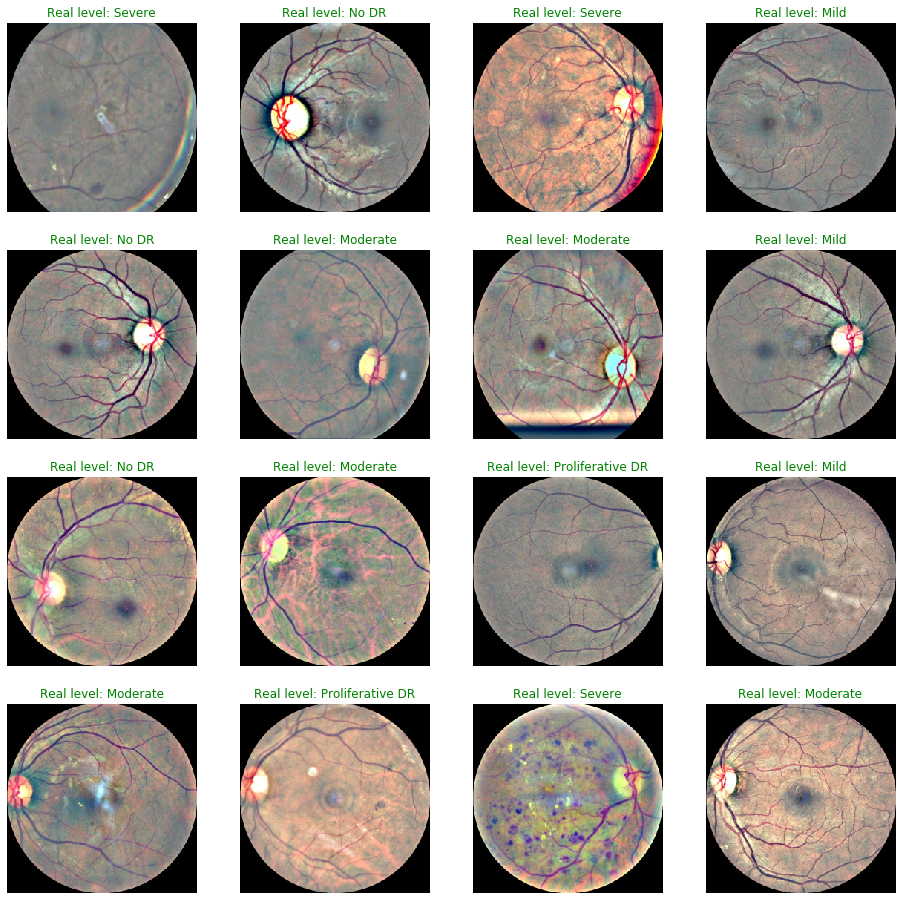

In [20]:
def print_info(img):
  img = img.numpy()
  print('Max:', img.max(), 'Min:', img.min(), 'Mean:',img.mean(), 
        'Size:', img.shape[:2], 'Type:', img.dtype)

print_info(imgs_1[23])
print_info(imgs_1[0])
print_info(imgs_2[10])
print_info(imgs_1[2])
print_info(imgs_1[15])

# print('Labels_1:', labels_1)

show_batch(imgs_1.numpy(), labels_1.numpy())

### 2.  Correctness of loss [CS231](http://cs231n.github.io/neural-networks-3/#sanitycheck) <font color='green'>OK</font>

Loss should be equal -ln(1/len(classes))

In [36]:
-np.log(1/len(CLASS_NAMES))

1.6094379124341003

### 3. Overfit a tiny subset of data [CS231](http://cs231n.github.io/neural-networks-3/#sanitycheck) <font color='green'>OK</font> 

### 4. Visualizing filters <font color='orange'>OK?</font> 

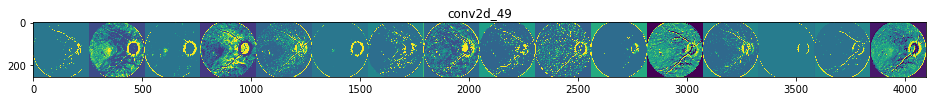

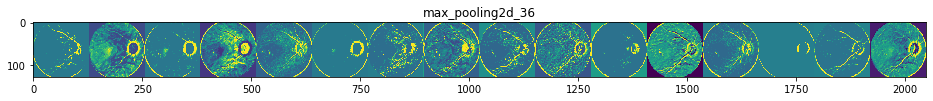

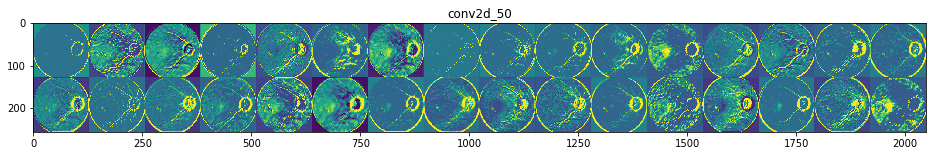

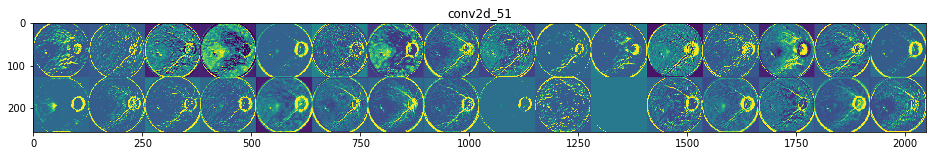

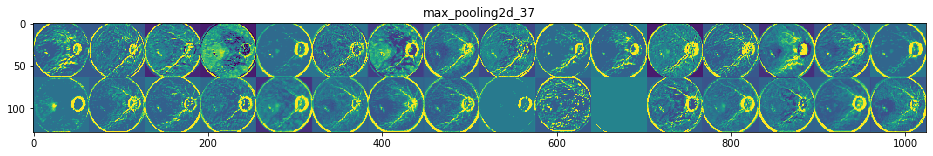

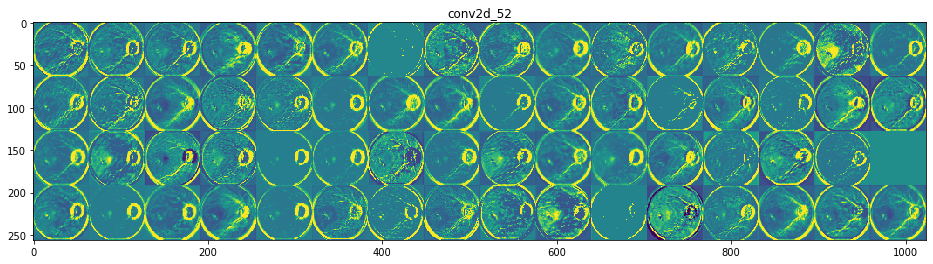

In [70]:
layer_outputs = [layer.output for layer in model.layers[:]] # Extracts the outputs of the top 12 layers
activation_model = models.Model(inputs=model.input, outputs=layer_outputs) # Creates a model that will return these outputs, given the model input
activations = activation_model.predict(image_batch) # Returns a list of five Numpy arrays: one array per layer activation
# first_layer_activation = activations[1]
# plt.matshow(first_layer_activation[0, :, :, 4], cmap='viridis')

layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
    
images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

### 4. Visualizing loss per epoch <font color='orange'>OK?</font> 

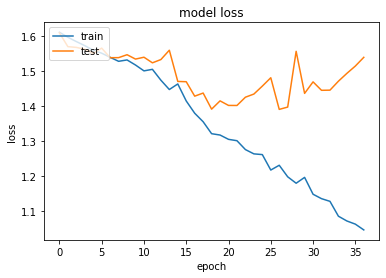

In [115]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()